In [1]:
import matplotlib as mpl
mpl.use('Agg')
mpl.rcParams['animation.embed_limit'] = 300  # 例: 50MBに増やす
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib import animation
import math
from IPython.display import HTML
import os
from matplotlib.animation import PillowWriter

%matplotlib inline

無次元系への変換

In [2]:
# =====================================================
# 1. 物理パラメータ（元コードと同じ形）
# =====================================================

# --- 進行波・電極 ---
Lx     = 0.08          # [m] x方向長さ
waves  = 1.0           # 波数（何波入っているか）
wave_v = 0.5           # [m/s] 波の位相速度
lambda_ = Lx / waves   # [m] 波長
f      = wave_v / lambda_           # [Hz]
k_wave = 2.0 * math.pi / lambda_    # [1/m]
omega  = 2.0 * math.pi * f          # [rad/s]

V0     = 1000.0        # [V] 電極電位振幅
phi0   = 0.0           # [rad] 初期位相
ground_z = 0.0         # [m] 地面高さ

# --- 定数 ---
g      = 1.625         # [m/s^2] 月面重力
eps_0  = 8.85e-12      # [F/m] 真空誘電率

# --- 粒子（代表値）---
R_phys = 3e-5          # [m] 粒子半径（例: 30 µm）
m_phys = 4e-10         # [kg] 粒子質量（例: R=30µmレゴリス相当）
q_phys = 6.5e-14         # [C] 粒子電荷

# --- 摩擦（物理的な係数）---
mu_s_phys = 10        # 静止摩擦係数（例）
mu_k_phys = 10        # 動摩擦係数（例）

# =====================================================
# 2. 無次元スケールと γ, β, Ω の計算
# =====================================================

# 代表電場スケール E0 ≈ k V0
E0 = k_wave * V0   # [V/m]

# 時間スケール T0: クーロン力と慣性のバランスから
#   T0^2 = m / (q k^2 V0)
T0 = math.sqrt(m_phys / (q_phys * (k_wave**2) * V0))

# 無次元パラメータ
gamma_phys = (m_phys * g) / (q_phys * E0)
beta_phys  = (q_phys * k_wave) / (16.0 * math.pi * eps_0 * V0)
Omega_phys = omega * T0



print("=== Physical parameters ===")
print(f"Lx      = {Lx:.3e} m")
print(f"lambda  = {lambda_:.3e} m")
print(f"k_wave  = {k_wave:.3e} 1/m")
print(f"omega   = {omega:.3e} rad/s")
print(f"V0      = {V0:.3e} V")
print(f"R       = {R_phys:.3e} m")
print(f"m       = {m_phys:.3e} kg")
print(f"q       = {q_phys:.3e} C")
print()
print("=== Derived scales ===")
print(f"E0      = {E0:.3e} V/m")
print(f"T0      = {T0:.3e} s  (time scale)")
print()
print("=== Dimensionless parameters from these physical values ===")
print(f"gamma   = {gamma_phys:.3e}   (gravity / electric)")
print(f"beta    = {beta_phys:.3e}   (image / electric)")
print(f"Omega   = {Omega_phys:.3e}   (omega * T0)")

# =====================================================
# 2.5  位置・半径の無次元化（確認用）
# =====================================================

# 長さスケール L0 = 1/k
L0 = 1.0 / k_wave

def x_hat_from_phys(x_phys):
    """物理位置 x[m] を無次元座標 x_hat に変換"""
    return x_phys / L0   # = k_wave * x_phys

def z_hat_from_phys(z_phys):
    return z_phys / L0

def R_hat_from_phys(R_phys_val):
    return R_phys_val / L0

# 例：初期位置 x0 = 0.02 m, z0 = 0.005 m のときの無次元量
x0_phys = 0.02   # [m]
z0_phys = 0.005  # [m]

x0_hat = x_hat_from_phys(x0_phys)
z0_hat = z_hat_from_phys(z0_phys)
R_hat  = R_hat_from_phys(R_phys)
ground_z_hat = z_hat_from_phys(ground_z)

print()
print("=== Example: dimensionless position / radius ===")
print(f"x0_phys = {x0_phys:.5e} m -> x_hat = {x0_hat:.5e}")
print(f"z0_phys = {z0_phys:.5e} m -> z_hat = {z0_hat:.5e}")
print(f"R_phys  = {R_phys:.5e} m -> R_hat = {R_hat:.5e}")
print(f"ground_z = {ground_z:.5e} m -> ground_z_hat = {ground_z_hat:.5e}")


=== Physical parameters ===
Lx      = 8.000e-02 m
lambda  = 8.000e-02 m
k_wave  = 7.854e+01 1/m
omega   = 3.927e+01 rad/s
V0      = 1.000e+03 V
R       = 3.000e-05 m
m       = 4.000e-10 kg
q       = 6.500e-14 C

=== Derived scales ===
E0      = 7.854e+04 V/m
T0      = 3.159e-02 s  (time scale)

=== Dimensionless parameters from these physical values ===
gamma   = 1.273e-01   (gravity / electric)
beta    = 1.148e-05   (image / electric)
Omega   = 1.240e+00   (omega * T0)

=== Example: dimensionless position / radius ===
x0_phys = 2.00000e-02 m -> x_hat = 1.57080e+00
z0_phys = 5.00000e-03 m -> z_hat = 3.92699e-01
R_phys  = 3.00000e-05 m -> R_hat = 2.35619e-03
ground_z = 0.00000e+00 m -> ground_z_hat = 0.00000e+00


定数

In [3]:
# =====================================================
# 3. 無次元シミュレーション用パラメータ
# =====================================================

# # # ここから下で、設定
#定数
R_hat = 5e-3    #粒子半径の無次元量
c_hat = R_hat     #地面に接している時、鏡像力の最大値の距離
gamma = 0.7     #重力/最大クーロン力
beta  = 1e-5    #鏡像力/最大クーロン力
Omega = 1.45     #角周波数×時間スケール 波速度/粒子が最大クーロン力から受ける速度
mu_k_hat = 0.2    #動摩擦係数の無次元量
mu_s_hat = 0.5


print()
print("=== Dimensionless parameters actually used in simulation ===")
print(f"gamma(sim) = {gamma:.3e}")
print(f"beta(sim)  = {beta:.3e}")
print(f"Omega(sim) = {Omega:.3e}")
print(f"R_hat(sim) = {R_hat:.3e}")
print(f"c_hat(sim) = {c_hat:.3e}")


=== Dimensionless parameters actually used in simulation ===
gamma(sim) = 7.000e-01
beta(sim)  = 1.000e-05
Omega(sim) = 1.450e+00
R_hat(sim) = 5.000e-03
c_hat(sim) = 5.000e-03


粒子クラス

In [4]:
class Particle:
    """
    無次元シミュレーション用の粒子。
    x, z, vx, vz, t などはすべて「無次元量」として扱う。
    （物理単位への変換はここでは一切行わない）
    """
    def __init__(self, x0, z0, vx0=0.0, vz0=0.0, R=1.0, label="", color=None):
        # --- 現在状態（すべて無次元量） ---
        self.x  = float(x0)
        self.z  = float(z0)
        self.vx = float(vx0)
        self.vz = float(vz0)
        self.R  = float(R)   # 粒子半径（無次元）

        self.label = label
        self.color = color

        # --- 接触・イベント関係 ---
        self.in_contact = False          # 地面と接触しているか
        self.bounce_count = 0            # 跳ねた回数
        self.collision_times = []        # 衝突した無次元時刻リスト

        # --- 履歴（無次元量）---
        self.hist = {
            "t":  [],
            "x":  [],
            "z":  [],
            "vx": [],
            "vz": [],

            # x方向
            "ax_tot":   [],   # 合力 a_x
            "ax_E":     [],   # 電場（クーロン）による a_x
            "ax_fric":  [],   # 摩擦による a_x（静止 or 動摩擦）
            # （必要なら）他の x 方向成分が出てきたときに拡張

            # z方向
            "az_tot":   [],   # 合力 a_z
            "az_E":     [],   # 電場（クーロン）による a_z
            "az_img":   [],   # 鏡像力による a_z
            "az_g":     [],   # 重力による a_z

            # 接触情報
            "N_hat":        [],   # 法線反力（無次元）
            "in_contact":   [],   # 地面と接触しているか（True/False を 0/1 でも可）

        }

    def save(self,
             t_hat,
             ax_tot=0.0, az_tot=0.0,
             ax_E=0.0,   az_E=0.0,
             az_img=0.0, az_g=0.0,
             ax_fric=0.0,
             N_hat=0.0,
             in_contact=False):
        """
        無次元時間 t における現在状態を履歴に保存
        """
        self.hist["t"].append(float(t_hat))
        self.hist["x"].append(self.x)
        self.hist["z"].append(self.z)
        self.hist["vx"].append(self.vx)
        self.hist["vz"].append(self.vz)

        # 加速度・接触情報
        self.hist["ax_tot"].append(ax_tot)
        self.hist["az_tot"].append(az_tot)
        self.hist["ax_E"].append(ax_E)
        self.hist["az_E"].append(az_E)
        self.hist["az_img"].append(az_img)
        self.hist["az_g"].append(az_g)
        self.hist["ax_fric"].append(ax_fric)
        self.hist["N_hat"].append(N_hat)
        self.hist["in_contact"].append(1 if in_contact else 0)

# -------------------------------------------------
    # 物理量から直接 Particle を作るクラスメソッド
    # -------------------------------------------------
    @classmethod
    def from_physical(cls,
                      x0_phys, z0_phys,
                      vx0=0.0, vz0=0.0,
                      R_phys_val=R_phys,
                      label="",
                      color=None):
        """
        物理座標 (x0_phys [m], z0_phys [m], R_phys [m]) から
        無次元粒子を生成するヘルパー。
        速度 vx0, vz0 は「すでに無次元化された値」として与える前提。
        （もし速度も物理単位から無次元化したくなったら、そのとき専用関数を追加）
        """
        x_hat0 = x_hat_from_phys(x0_phys)
        z_hat0 = z_hat_from_phys(z0_phys)
        R_hat  = R_hat_from_phys(R_phys_val)

        return cls(
            x0=x_hat0,
            z0=z_hat0,
            vx0=vx0,
            vz0=vz0,
            R=R_hat,
            label=label,
            color=color,
        )

関数

In [5]:
# =====================================================
# 5. 無次元運動方程式：各力の項
# =====================================================
### SI単位の物理量使う時
# EPS_CONTACT_phys = max(1e-10, 1e-5 * R_phys)  # 物理単位での接触判定用しきい値
# EPS_CONTACT = EPS_CONTACT_phys / L0  # 無次元化したもの
# VEL_EPS_phys = 1e-9 # [m/s] 物理単位での速度ゼロ判定用しきい値
# VEL_EPS = VEL_EPS_phys / (L0 / T0)  # 無次元化したもの

### 無次元量使う時
contact_rel = 1e-4
EPS_CONTACT = contact_rel * R_hat

VEL_EPS = 1e-6

def electric_accel(p: Particle, t: float):
    """
    クーロン力（進行波電場）による無次元加速度項 (a_x, a_z) を返す。
    t は無次元時間。
    """
    phase = p.x - Omega * t + phi0
    exp_factor = math.exp(-p.z)

    ax = -exp_factor * math.cos(phase)
    az =  exp_factor * math.sin(phase)
    return ax, az

def image_accel(p: Particle):
    """
    鏡像力による無次元加速度項 (a_x, a_z) を返す。
    x方向成分は 0、z方向のみ。
    """
    # z が 0 に近づきすぎると 1/z^2 が発散するので、最小値を入れておく
    z_eff = (p.z - p.R) + c_hat - ground_z_hat

    s_min = 0.1 * p.R  # とりあえず 0.1R など
    if z_eff < s_min:
        z_eff = s_min

    az = -beta / (z_eff**2)
    return 0.0, az

def gravity_accel():
    """
    重力による無次元加速度項 (a_x, a_z) を返す。
    x 方向は 0、z 方向のみ一定。
    """
    az = -gamma
    return 0.0, az


def contact_and_friction_accel(p: Particle, t: float):
    """
    接触判定＋静止摩擦／動摩擦込みの加速度を計算する。
    戻り値:
        ax_total, az_total, in_contact, N_hat
    """
    # まず「電場＋鏡像力＋重力」の項を計算
    ax_e, az_e = electric_accel(p, t)
    _,   az_img = image_accel(p)
    _,   az_g   = gravity_accel()

    az_free = az_e + az_img + az_g

    # 接触判定（粒子下端が地面を下回っていれば接触とみなす）
    in_contact = ((p.z - p.R) <= (ground_z_hat + EPS_CONTACT))

    N_hat = 0.0
    az_total = az_free

    # --- 法線反力の計算 ---
    if in_contact and az_free < 0.0:
        # 下向きに加速しようとしているので、床が押し返す
        # z方向加速度を 0 にするように反力を入れる
        N_hat = -az_free
        az_total = 0.0
    else:
        # それ以外は反力なし（浮いている or 上向き加速）
        N_hat = 0.0
        az_total = az_free
        # 浮き上がるときは接触フラグを落とすことも考えられる
        if in_contact and az_free >= 0.0:
            in_contact = False

    # --- x方向：摩擦 ---
    ax_fric  = 0.0        # まず摩擦は0としておく
    ax_total = ax_e

    if in_contact:
        # 静止摩擦条件のチェック
        # 1. 速度がほぼゼロ
        # 2. クーロン力による加速度が静止摩擦限界以下
        if (abs(p.vx) < VEL_EPS) and (abs(ax_e) <= mu_s_hat * N_hat):
            # 静止摩擦：滑り出さないように完全に打ち消す
            ax_fric  = -ax_e      # 電場を打ち消す向き・大きさ
            ax_total = ax_e + ax_fric   # = 0
        else:
            # 動摩擦：速度方向と逆向きに mu_k * N_hat を加える
            if abs(p.vx) > VEL_EPS:
                sign = math.copysign(1.0, p.vx)
            else:
                # 速度がほぼ 0 なら、電場による加速方向に滑り出すと仮定
                sign = math.copysign(1.0, ax_e) if ax_e != 0.0 else 0.0

            ax_fric  = -mu_k_hat * N_hat * sign
            ax_total = ax_e + ax_fric
            # ax_total = 0.0  #摩擦力大きくする時

    return ax_total, az_total, in_contact, N_hat, ax_fric


def accel_total(p: Particle, t: float):
    """
    粒子 p の無次元加速度 (ax, az) を返す高水準関数。
    - クーロン力
    - 鏡像力
    - 重力
    - 接触・静止摩擦・動摩擦
    をすべて含めたもの。
    """
    ax, az, in_contact, N_hat, ax_fric = contact_and_friction_accel(p, t)

    # 接触状態を粒子にも反映しておく（イベント判定などに使える）
    p.in_contact = in_contact
    return ax, az


# =====================================================
# RK4 1ステップ分
# =====================================================

def rk4_step(p: Particle, t: float, dt: float):
    """
    粒子 p を、無次元時間 t から t+dt まで RK4 で1ステップ進める。
    p の状態 (x, z, vx, vz) を in-place で更新する。
    """

    # 現在状態を退避しておく
    x0, z0 = p.x, p.z
    vx0, vz0 = p.vx, p.vz
    in_contact0 = p.in_contact

    # accel_total を「任意の状態 (x,z,vx,vz,t) に対して」使うためのヘルパ
    def deriv(x, z, vx, vz, t_local):
        """
        状態 (x,z,vx,vz) における微分:
            dx/dt = vx
            dz/dt = vz
            dvx/dt, dvz/dt = accel_total(...)
        を返す。
        """
        # p を一時的にこの状態にして accel_total を呼ぶ
        p.x, p.z, p.vx, p.vz = x, z, vx, vz
        ax, az = accel_total(p, t_local)

        # 状態を元に戻す（p.in_contact も戻す）
        p.x, p.z, p.vx, p.vz = x0, z0, vx0, vz0
        p.in_contact = in_contact0

        return vx, vz, ax, az

    # k1
    k1_x, k1_z, k1_vx, k1_vz = deriv(x0, z0, vx0, vz0, t)

    # k2
    x2  = x0  + 0.5 * dt * k1_x
    z2  = z0  + 0.5 * dt * k1_z
    vx2 = vx0 + 0.5 * dt * k1_vx
    vz2 = vz0 + 0.5 * dt * k1_vz
    k2_x, k2_z, k2_vx, k2_vz = deriv(x2, z2, vx2, vz2, t + 0.5 * dt)

    # k3
    x3  = x0  + 0.5 * dt * k2_x
    z3  = z0  + 0.5 * dt * k2_z
    vx3 = vx0 + 0.5 * dt * k2_vx
    vz3 = vz0 + 0.5 * dt * k2_vz
    k3_x, k3_z, k3_vx, k3_vz = deriv(x3, z3, vx3, vz3, t + 0.5 * dt)

    # k4
    x4  = x0  + dt * k3_x
    z4  = z0  + dt * k3_z
    vx4 = vx0 + dt * k3_vx
    vz4 = vz0 + dt * k3_vz
    k4_x, k4_z, k4_vx, k4_vz = deriv(x4, z4, vx4, vz4, t + dt)

    # RK4 更新
    p.x  = x0  + (dt / 6.0) * (k1_x  + 2.0 * k2_x  + 2.0 * k3_x  + k4_x)
    p.z  = z0  + (dt / 6.0) * (k1_z  + 2.0 * k2_z  + 2.0 * k3_z  + k4_z)
    p.vx = vx0 + (dt / 6.0) * (k1_vx + 2.0 * k2_vx + 2.0 * k3_vx + k4_vx)
    p.vz = vz0 + (dt / 6.0) * (k1_vz + 2.0 * k2_vz + 2.0 * k3_vz + k4_vz)

    # 最後に、この新しい状態に対して in_contact を更新しておく
    now_in_contact = (p.z - p.R) <= (ground_z_hat + EPS_CONTACT)
    p.in_contact = now_in_contact



def t_end_hat_from_cycles(N_cycles, Omega):
    """
    N_cycles：何周期見るか
    Omega：無次元角周波数
    """
    T_hat = 2.0 * math.pi / Omega         # 無次元1周期
    t_end_hat = N_cycles * T_hat          # 無次元時間の合計
    return t_end_hat



def choose_dt_hat_for_Omega(Omega: float):
    """
    Ω に応じて、無次元時間ステップ dt_far/mid/near を決めるヘルパー。
    目安:
      - 遠方:   1周期あたり ~600ステップ
      - 中間:   ~6000ステップ
      - 近接:  ~60000ステップ
    """

    # 安全側の係数（必要なら後で変えてOK）
    fac_far  = 1e-2   # 0.01 / Ω
    fac_mid  = 1e-3   # 0.001 / Ω
    fac_near = 1e-4   # 0.00001 / Ω

    dt_far_hat  = fac_far  / Omega
    dt_mid_hat  = fac_mid  / Omega
    dt_near_hat = fac_near / Omega

    # 履歴保存間隔
    save_dt_hat = 5*dt_near_hat

    return dt_far_hat, dt_mid_hat, dt_near_hat, save_dt_hat


def simulate(
    p: Particle,
    t_end_hat: float,
    dt_far_hat: float,
    dt_mid_hat: float,
    dt_near_hat: float,
    save_dt_hat: float | None = None,
    ):
    """
    物理時間 [s] ベースの設定（t_end, dt_far, dt_mid, dt_near）を引数に取り、
    内部で無次元時間に変換してシミュレーションする。
    """

    t_hat  = 0.0            # 無次元時間

    # 初期接触状態
    in_contact = (p.z - p.R) <= (ground_z_hat + EPS_CONTACT)
    last_bounce_time = -1e9          # あり得ないくらい小さい値で初期化
    min_bounce_interval = 1        # これが「同一衝突とみなす時間幅」
    p.in_contact = in_contact
    prev_in_contact = in_contact

    # --- 初期状態の加速度を計算して保存 ---
    ax_E0, az_E0 = electric_accel(p, t_hat)
    _,   az_img0 = image_accel(p)
    _,   az_g0   = gravity_accel()
    ax_tot0, az_tot0, in_contact0, N_hat0, ax_fric0 = contact_and_friction_accel(p, t_hat)


    # 初期状態を保存
    p.save(
        t_hat,
        ax_tot=ax_tot0,
        az_tot=az_tot0,
        ax_E=ax_E0,
        az_E=az_E0,
        ax_fric=ax_fric0,
        az_img=az_img0,
        az_g=az_g0,
        N_hat=N_hat0,
        in_contact=in_contact0,
    )
    events = []
    time_since_save_hat = 0.0

    while t_hat < t_end_hat:
        # ---- 元コードと同じロジックで dt_hat を決める ----
        # ここは z, R, EPS_CONTACT を無次元 → 物理に戻してもいいし、
        # 無次元のまま「EPS_CONTACT も無次元」にして比較してもいい。
        if (p.z - p.R) > 50.0 * EPS_CONTACT:
            dt_hat = dt_far_hat
        elif (p.z - p.R) > 10.0 * EPS_CONTACT:
            dt_hat = dt_mid_hat
        else:
            dt_hat = dt_near_hat

        if t_hat + dt_hat > t_end_hat:
            dt_hat = t_end_hat - t_hat

        vz_before = p.vz

        # 1ステップ進める（無次元時間で）
        rk4_step(p, t_hat, dt_hat)
        t_hat  += dt_hat

        # 地面より下にめり込んだ場合の補正などは今の simulate と同じでOK
        if (p.z - p.R) < ground_z_hat:
            p.z = ground_z_hat + p.R
            p.vz = 0.0
            # p.vx = 0.0  #摩擦力大きくする時

        now_in_contact = (p.z - p.R) <= (ground_z_hat + EPS_CONTACT)
        p.in_contact = now_in_contact

        if (not prev_in_contact) and now_in_contact:
            if (vz_before < 0.0) and (t_hat - last_bounce_time > min_bounce_interval):
                p.bounce_count += 1
                p.collision_times.append(t_hat)  # 物理時間で記録してもいい
                events.append({"time": t_hat, "type": "bounce"})
                last_bounce_time = t_hat   # ここを必ず更新！

        if prev_in_contact and (not now_in_contact):
            events.append({"time": t_hat, "type": "lift-off"})

        prev_in_contact = now_in_contact

        # 履歴保存（ここでは無次元時間で保存している）
        time_since_save_hat += dt_hat
        if (save_dt_hat is None) or (time_since_save_hat >= save_dt_hat):
            # 現在状態で各加速度成分を計算
            ax_E, az_E = electric_accel(p, t_hat)
            _,   az_img = image_accel(p)
            _,   az_g   = gravity_accel()
            ax_tot, az_tot, in_contact_cf, N_hat, ax_fric = contact_and_friction_accel(p, t_hat)

            p.save(
                t_hat,
                ax_tot=ax_tot,
                az_tot=az_tot,
                ax_E=ax_E,
                az_E=az_E,
                ax_fric=ax_fric,
                az_img=az_img,
                az_g=az_g,
                N_hat=N_hat,
                in_contact=in_contact_cf,
            )
            
            time_since_save_hat = 0.0

    return p.hist, events


def compute_energy(hist_nd, Omega, R_hat, phi0=0.0):
    """
    無次元履歴 hist_nd から
      ψ, ψ', V(ψ), H = 1/2 ψ'^2 + A(1 - sinψ)
    を計算して返す。
    """
    t_hat = np.array(hist_nd["t"])
    x_hat = np.array(hist_nd["x"])
    vx_hat = np.array(hist_nd["vx"])

    # 位相差 ψ, 速度差 ψ' = v_x - Ω
    psi     = x_hat - Omega * t_hat + phi0
    psi_dot = vx_hat - Omega

    # 振幅 A ≃ e^{-R̂}（z≃R̂ に固定した近似）
    A = np.exp(-R_hat)

    # 有効ポテンシャル（定数シフト 1 は見た目のためだけで物理的には不要）
    # V = A * (1.0 - np.sin(psi))
    V = A * np.sin(psi)

    # 有効エネルギー
    H = 0.5 * psi_dot**2 + V

    return t_hat, psi, psi_dot, V, H


輸送効率用関数

In [6]:
#周期境界の排除
def unwrap_periodic(x_arr, Lx=2*np.pi):
    """
    x が [0, Lx) の周期境界だと仮定して unwrap する簡易関数。
    すでに同様の関数がある場合は、そちらを使ってもよい。
    """
    x = np.array(x_arr, dtype=float)
    dx = np.diff(x)
    x_unwrapped = x.copy()
    offset = 0.0

    for j in range(1, len(x)):
        if abs(x[j] - x[j-1]) > Lx/2:
            # 境界をまたいだと判断
            if x[j] < x[j-1]:
                offset += Lx
            else:
                offset -= Lx
        x_unwrapped[j] += offset

    return x_unwrapped

#各粒子の平均速度の算出
# 各粒子の平均速度の算出（最初の数周期を捨てるオプション付き）
def compute_mean_velocity_from_hist(hist_nd, Lx=2*np.pi, discard_fraction: float = 0.0):
    """
    1 粒子の履歴 hist_nd から、長時間平均速度 v_mean を計算する。
    v_mean = (x(T) - x(t_use_start)) / (T - t_use_start)

    x は周期境界付きの位相座標を想定しているので、
    必要に応じて unwrap してから差分をとる。

    discard_fraction:
        0.0 なら全区間を使用
        0.3 なら、全時間のうち最初の 30% を捨てて残り 70% だけで平均速度をとる
    """
    t = np.array(hist_nd["t"], dtype=float)
    x = np.array(hist_nd["x"], dtype=float)

    if len(t) < 2:
        return 0.0

    # 周期境界をほどく
    x_unw = unwrap_periodic(x, Lx=Lx)

    # 使う時間区間の決定
    t0 = t[0]
    t1 = t[-1]
    dt_total = t1 - t0
    if dt_total <= 0:
        return 0.0

    if discard_fraction <= 0.0:
        # 何も捨てない
        use_mask = np.ones_like(t, dtype=bool)
    else:
        # 全体時間の discard_fraction ぶんを捨てる
        t_use_start = t0 + discard_fraction * dt_total
        use_mask = t >= t_use_start

        # 万一、点数が少なすぎる場合は全区間にフォールバック
        if np.sum(use_mask) < 2:
            use_mask = np.ones_like(t, dtype=bool)

    t_use = t[use_mask]
    x_use = x_unw[use_mask]

    dt_use = t_use[-1] - t_use[0]
    if dt_use <= 0:
        return 0.0

    v_mean = (x_use[-1] - x_use[0]) / dt_use
    return v_mean


#エネルギー的にトラップされているか
def is_synchronous_by_energy(hist_nd,
                             Omega_val: float,
                             R_hat_val: float,
                             phi0: float = 0.0,
                             margin: float = 0.02,
                             discard_fraction: float = 0.0) -> bool:
    """
    エネルギー H がセパラトリクス H = A の内側に
    （十分時間が経ったあとの区間で）とどまっているかどうかで
    「同期（トラップ）」判定する。

    条件:
        max_{late}(H) <= A * (1 + margin)

    discard_fraction:
        0.0 : 全時間で max(H) をとる（従来と同じ）
        0.3 : 全体時間のうち最初の 30% を捨てた残りで max(H) をとる
    """

    # 既存の compute_energy を使う
    t_hat, psi, psi_dot, V, H = compute_energy(
        hist_nd,
        Omega=Omega_val,
        R_hat=R_hat_val,
        phi0=phi0
    )

    A = np.exp(-R_hat_val)

    # --- 使う時間区間を決める（平均速度と同じロジック） ---
    if len(t_hat) < 2:
        H_use = H
    else:
        t0 = t_hat[0]
        t1 = t_hat[-1]
        dt_total = t1 - t0

        if dt_total <= 0 or discard_fraction <= 0.0:
            # そのまま全区間を使う
            H_use = H
        else:
            t_use_start = t0 + discard_fraction * dt_total
            use_mask = t_hat >= t_use_start

            # 点が少なすぎる場合はフォールバック
            if np.sum(use_mask) < 2:
                H_use = H
            else:
                H_use = H[use_mask]

    H_max = np.max(H_use)

    return H_max <= A * (1.0 + margin)



def compute_flux_sync_for_params(
    Omega_val: float,
    mu_s_hat_val: float,
    mu_k_hat_val: float,
    N_particles: int = 50,
    N_cycles: int = 50,
    x0_min: float = 0.0,
    x0_max: float = 2.0*np.pi,
    R_hat_val: float = R_hat,
    phi0_val: float = 0.0,
    energy_margin: float = 0.02,
    discard_fraction_for_mean: float = 0.0,  # ★追加：v_mean 計算時に捨てる比率
):
    """
    与えた (Ω, μ_s_hat, μ_k_hat) について、
    初期位相 x0 を [x0_min, x0_max) に一様に並べた N_particles 個の粒子を
    シミュレーションし、「エネルギー的に同期している粒子のみ」を使って
    フラックス

        Φ_sync = (1/N) Σ_i [ sync_i ? max(v_mean_i, 0) : 0 ]

    を計算して返す。

    戻り値:
        flux_sync : Φ_sync（同期粒子のみをカウントした右向きフラックス）
        v_means   : 各粒子の平均速度配列
        x0_list   : 各粒子の初期位相配列
        sync_flags: 各粒子が同期かどうか (True/False) の配列
    """

    # ---- グローバルパラメータの設定 ----
    globals()["Omega"]    = Omega_val
    globals()["mu_s_hat"] = mu_s_hat_val
    globals()["mu_k_hat"] = mu_k_hat_val

    # ---- 時間設定 ----
    t_end_hat = t_end_hat_from_cycles(N_cycles, Omega_val)
    dt_far_hat, dt_mid_hat, dt_near_hat, save_dt_hat = choose_dt_hat_for_Omega(Omega_val)

    # ---- 初期位相の一様サンプリング ----
    x0_list = np.linspace(x0_min, x0_max, N_particles, endpoint=False)

    v_means    = []
    sync_flags = []

    for idx, x0 in enumerate(x0_list):
        # 粒子を初期化
        p = Particle(
            x0=x0,
            z0=R_hat_val,
            vx0=0.0,
            vz0=0.0,
            R=R_hat_val,
            label=f"x0={x0:.3f}",
            color=None,
        )

        # シミュレーション
        hist_nd, events = simulate(
            p,
            t_end_hat=t_end_hat,
            dt_far_hat=dt_far_hat,
            dt_mid_hat=dt_mid_hat,
            dt_near_hat=dt_near_hat,
            save_dt_hat=save_dt_hat,
        )

        # 平均速度（最初の discard_fraction_for_mean 部分を捨てる）
        v_mean = compute_mean_velocity_from_hist(
            hist_nd,
            Lx=2.0*np.pi,
            discard_fraction=discard_fraction_for_mean,
        )
        v_means.append(v_mean)

        # エネルギー的な同期判定
        is_sync = is_synchronous_by_energy(
            hist_nd,
            Omega_val=Omega_val,
            R_hat_val=R_hat_val,
            phi0=phi0_val,
            margin=energy_margin,
            discard_fraction=discard_fraction_for_mean,
        )
        sync_flags.append(is_sync)

    v_means    = np.array(v_means,    dtype=float)
    sync_flags = np.array(sync_flags, dtype=bool)

    # 右向き同期粒子（フラックスに実際に寄与する粒子）
    mask_sync = sync_flags & (v_means > 0.0)

    # S_trap: 右向き同期粒子の割合
    if len(v_means) > 0:
        S_trap = np.mean(mask_sync)
    else:
        S_trap = 0.0

    # 同期粒子の平均速度 <v>_sync
    if np.any(mask_sync):
        v_sync = np.mean(v_means[mask_sync])
    else:
        v_sync = 0.0

    # フラックス (1/N Σ sync_i ? v_mean_i : 0) ・・・これまで通り
    v_contrib = np.where(mask_sync, v_means, 0.0)
    flux_vmean = np.mean(v_contrib)

    # Ω から計算した理論型フラックス S_trap * Ω も保存
    flux_omega = S_trap * Omega_val

    return flux_vmean, flux_omega, v_means, x0_list, sync_flags, S_trap, v_sync





Ωスイープ

In [7]:
# ============================================================
#  摩擦係数を固定して Ω を sweep し、各種量を保存する関数
# ============================================================

def sweep_Omega_simulation(
    Omega_min: float = 0.5,
    Omega_max: float = 2.0,
    n_Omega: int = 15,
    mu_s: float = 0.0,
    mu_k: float = 0.0,
    N_particles: int = 50,
    N_cycles: int = 5,
    R_hat_val: float = R_hat,
    energy_margin: float = 0.0,
    discard_fraction_for_mean: float = 0.0,
    phi0_val: float = 0.0,
    stop_if_zero_flux: bool = False,   # 必要なら true にして早期終了
    flux_eps: float = 1e-3,
):
    """
    摩擦係数 (mu_s, mu_k) を固定して Ω をスイープし、
    各 Ω ごとに

        - flux_vmean : v_mean から計算したフラックス
        - flux_omega : S_trap * Ω で計算したフラックス
        - S_trap     : 右向き同期粒子の割合
        - v_sync     : 同期粒子の平均速度

    を評価する。

    戻り値:
        Omega_list       : np.array, 形状 (n_Omega,)
        flux_vmean_list  : np.array, 形状 (n_Omega,)
        flux_omega_list  : np.array, 形状 (n_Omega,)
        Strap_list       : np.array, 形状 (n_Omega,)
        v_sync_list      : np.array, 形状 (n_Omega,)
    """

    Omega_list       = np.linspace(Omega_min, Omega_max, n_Omega)
    flux_vmean_list  = []
    flux_omega_list  = []
    Strap_list       = []
    v_sync_list      = []

    #全Ωについての同期フラグを保存するリスト
    sync_flags_all = []
    x0_list_ref = None   # 最初のΩの x0_list を保存しておく

    print(f"=== Sweep Omega with fixed (mu_s, mu_k) = ({mu_s:.3f}, {mu_k:.3f}) ===")

    for i, Omega_val in enumerate(Omega_list, start=1):
        print(f"[{i}/{len(Omega_list)}]  Omega = {Omega_val:.4f}  "
              f"(mu_s={mu_s:.2f}, mu_k={mu_k:.2f}) ... ", end="")

        (flux_vmean,
         flux_omega,
         v_means,
         x0_list,
         sync_flags,
         S_trap,
         v_sync) = compute_flux_sync_for_params(
            Omega_val      = Omega_val,
            mu_s_hat_val   = mu_s,
            mu_k_hat_val   = mu_k,
            N_particles    = N_particles,
            N_cycles       = N_cycles,
            x0_min         = 0.0,
            x0_max         = 2.0*np.pi,
            R_hat_val      = R_hat_val,
            energy_margin  = energy_margin,
            phi0_val       = phi0_val,
            discard_fraction_for_mean = discard_fraction_for_mean,
        )

        flux_vmean_list.append(flux_vmean)
        flux_omega_list.append(flux_omega)
        Strap_list.append(S_trap)
        v_sync_list.append(v_sync)

        # 追加：同期フラグを保存
        sync_flags_all.append(sync_flags.astype(bool))
        if x0_list_ref is None:
            x0_list_ref = np.array(x0_list, dtype=float)

        print(f"flux_vmean = {flux_vmean:.6f},  S_trap = {S_trap:.3f},  v_sync = {v_sync:.3f}")

        # もし全区間ほぼ 0 になったら早期に打ち切るオプション
        if stop_if_zero_flux and abs(flux_vmean) < flux_eps:
            print(f"  → flux_vmean ≲ {flux_eps:.1e} なので、残りの Ω スイープを省略します。")
            # ここでループを抜けると、Omega_list の残りは使わない
            # 途中までの要素だけを返すように切り詰める
            Omega_list      = Omega_list[:i]
            break

    return (
        np.array(Omega_list,      dtype=float),
        np.array(flux_vmean_list, dtype=float),
        np.array(flux_omega_list, dtype=float),
        np.array(Strap_list,      dtype=float),
        np.array(v_sync_list,     dtype=float),
        x0_list_ref,                                  # ★ 追加
        np.array(sync_flags_all, dtype=bool),         # ★ 追加: shape (n_Omega, N_particles)
    )


理論

Omega_max (theory)  = 1.30100
Phi_sync_max (theory) = 0.71263


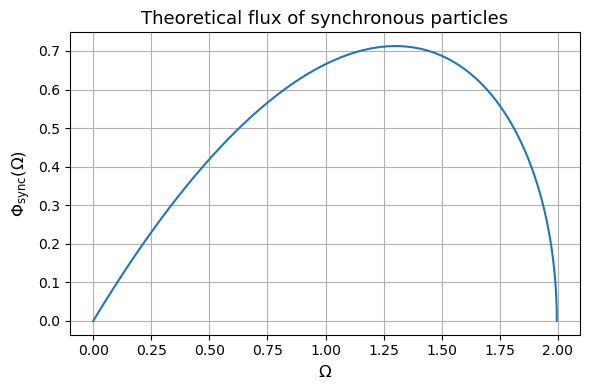

In [8]:
# ===============================
# 1. パラメータ設定
# ===============================

# 例として、あなたの無次元半径 R_hat から A = exp(-R_hat) を定義
# （ここは状況に応じて好きに変えてOK）
A = np.exp(-R_hat)         # 有効ポテンシャル振幅 A

# Ω の掃引範囲：理論上 0 <= Ω <= 2*sqrt(A)
Omega_min = 0.0
Omega_max = 2.0 * np.sqrt(A)
n_Omega   = 5000            # 分解能（多めにしておくと綺麗なカーブになる）

# ===============================
# 2. フラックスの理論式（関数化）
# ===============================

def phi_sync(Omega, A):
    """
    同期粒子のみをカウントした理論フラックス Φ_sync(Ω) を返す。
    Ω, A はスカラー or NumPy 配列 OK。
    
    Φ_sync(Ω) = Ω * [ 1/2 + (1/π) * arcsin( 1 - Ω^2 / (2A) ) ]
    ただし、arcsin の引数が [-1,1] を外れたところでは Φ_sync = 0 とする。
    """
    Omega = np.asarray(Omega)
    
    # s_c = 1 - Ω^2 / (2A)
    s_c = 1.0 - Omega**2 / (2.0 * A)
    
    # 結果用配列を 0 で初期化
    Phi = np.zeros_like(Omega)
    
    # 有効な範囲（トラップあり）のマスク：-1 <= s_c <= 1
    mask = (s_c >= -1.0) & (s_c <= 1.0)
    
    # その範囲で S_trap と Φ_sync を計算
    S_trap = 0.5 + (1.0 / np.pi) * np.arcsin(s_c[mask])
    Phi[mask] = Omega[mask] * S_trap
    
    return Phi

# ===============================
# 3. グラフ用データ生成
# ===============================

Omega_vals = np.linspace(Omega_min, Omega_max, n_Omega)
Phi_vals   = phi_sync(Omega_vals, A)

# 最大値とその Ω も確認したければ
idx_max = np.argmax(Phi_vals)
Omega_max_flux = Omega_vals[idx_max]
Phi_max_flux   = Phi_vals[idx_max]
print(f"Omega_max (theory)  = {Omega_max_flux:.5f}")
print(f"Phi_sync_max (theory) = {Phi_max_flux:.5f}")

# ===============================
# 4. プロット
# ===============================

plt.figure(figsize=(6,4))
plt.plot(Omega_vals, Phi_vals)
plt.xlabel(r'$\Omega$', fontsize=12)
plt.ylabel(r'$\Phi_{\mathrm{sync}}(\Omega)$', fontsize=12)
plt.title(r'Theoretical flux of synchronous particles', fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# ============================================================
#  理論 vs シミュレーション の比較プロット
# ============================================================

def plot_theory_vs_sim(Omega_list, flux_sim, A, n_theory=5000):

    # --- 理論フラックス ---
    Omega_vals_theory = np.linspace(0, 2*np.sqrt(A), n_theory)
    Phi_vals_theory   = phi_sync(Omega_vals_theory, A)

    # --- プロット ---
    plt.figure(figsize=(7, 5))

    # 理論曲線
    plt.plot(Omega_vals_theory, Phi_vals_theory,
             label="Theory (synchronous-only)",
             linewidth=2)

    # シミュレーション結果
    # plt.scatter(Omega_list, flux_sim,
    #             color="red", s=40,
    #             label="Simulation (μ=0)",
    #             zorder=5)
    plt.plot(Omega_list, flux_sim,
         "o-",            # 点＋線
         color="red",
         label="Simulation (μ=0)",
         zorder=5)


    plt.xlabel(r'$\Omega$', fontsize=12)
    plt.ylabel(r'Flux', fontsize=12)
    plt.title("Flux comparison: Theory vs Simulation (μ=0)", fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


メイン

=== Sweep Omega with fixed (mu_s, mu_k) = (0.000, 0.000) ===
[1/19]  Omega = 0.1000  (mu_s=0.00, mu_k=0.00) ... flux_vmean = 0.096954,  S_trap = 0.970,  v_sync = 0.100
[2/19]  Omega = 0.2000  (mu_s=0.00, mu_k=0.00) ... flux_vmean = 0.185909,  S_trap = 0.930,  v_sync = 0.200
[3/19]  Omega = 0.3000  (mu_s=0.00, mu_k=0.00) ... flux_vmean = 0.272926,  S_trap = 0.910,  v_sync = 0.300
[4/19]  Omega = 0.4000  (mu_s=0.00, mu_k=0.00) ... flux_vmean = 0.347884,  S_trap = 0.870,  v_sync = 0.400
[5/19]  Omega = 0.5000  (mu_s=0.00, mu_k=0.00) ... flux_vmean = 0.413633,  S_trap = 0.830,  v_sync = 0.498
[6/19]  Omega = 0.6000  (mu_s=0.00, mu_k=0.00) ... flux_vmean = 0.486020,  S_trap = 0.810,  v_sync = 0.600
[7/19]  Omega = 0.7000  (mu_s=0.00, mu_k=0.00) ... flux_vmean = 0.539778,  S_trap = 0.770,  v_sync = 0.701
[8/19]  Omega = 0.8000  (mu_s=0.00, mu_k=0.00) ... flux_vmean = 0.587531,  S_trap = 0.730,  v_sync = 0.805
[9/19]  Omega = 0.9000  (mu_s=0.00, mu_k=0.00) ... flux_vmean = 0.636815,  S_trap =

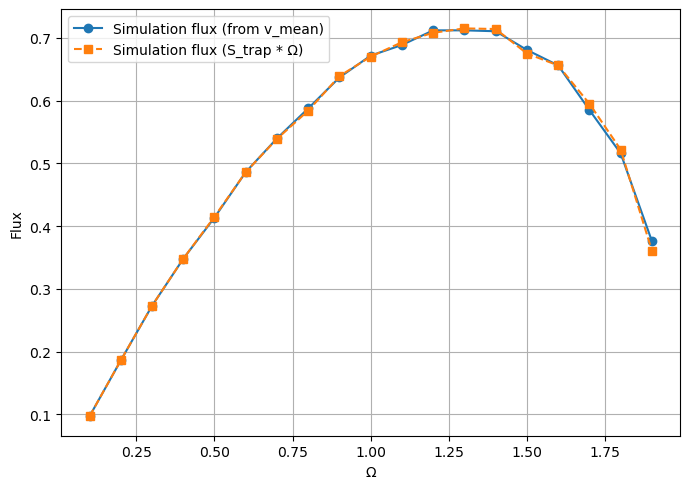

In [10]:
mu_s = 0.0
mu_k = 0.0

Omega_min = 0.1
Omega_max = 1.9
n_Omega   = 19

N_particles = 100
N_cycles    = 15
discard_frac = 0.3

(Omega_list,
 flux_vmean_list,
 flux_omega_list,
 Strap_list,
 v_sync_list,
 x0_list,
 sync_flags_all,) = sweep_Omega_simulation(
    Omega_min  = Omega_min,
    Omega_max  = Omega_max,
    n_Omega    = n_Omega,
    mu_s       = mu_s,
    mu_k       = mu_k,
    N_particles= N_particles,
    N_cycles   = N_cycles,
    R_hat_val  = R_hat,
    energy_margin = 0.005,
    discard_fraction_for_mean = discard_frac,
    phi0_val   = phi0,
    stop_if_zero_flux = False,
)

# 例: v_mean版 vs S_trap*Ω を同じグラフに描く
plt.figure(figsize=(7,5))
plt.plot(Omega_list, flux_vmean_list, "o-", label="Simulation flux (from v_mean)")
plt.plot(Omega_list, flux_omega_list, "s--", label="Simulation flux (S_trap * Ω)")
plt.xlabel(r"$\Omega$")
plt.ylabel("Flux")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# --- 理論値との比較 ---

A = np.exp(R_hat * -1.0)   # A = exp(-R_hat)

def theory_Strap(Omega, A):
    s_c = 1.0 - Omega**2/(2.0*A)
    S = np.zeros_like(Omega, dtype=float)

    mask = (s_c >= -1.0) & (s_c <= 1.0)
    S[mask] = 0.5 + (1.0/np.pi)*np.arcsin(s_c[mask])
    return S

def theory_flux(Omega, A):
    S = theory_Strap(Omega, A)
    return Omega * S

Omega_arr = np.array(Omega_list)

Strap_theory = theory_Strap(Omega_arr, A)
flux_theory  = theory_flux(Omega_arr, A)

# 誤差（例えば二乗平均平方根）
rmse_flux  = np.sqrt(np.mean((flux_vmean_list - flux_theory)**2))
rmse_Strap = np.sqrt(np.mean((Strap_list     - Strap_theory)**2))

print("RMSE flux (sim vs theory): ", rmse_flux)
print("RMSE Strap (sim vs theory):", rmse_Strap)

# 簡単な数値一覧
for Om, f_sim, f_th, S_sim, S_th in zip(
        Omega_arr, flux_vmean_list, flux_theory, Strap_list, Strap_theory):
    print(f"Omega={Om:.3f} : "
          f"flux_sim={f_sim:.4f}, flux_th={f_th:.4f}, "
          f"S_sim={S_sim:.4f}, S_th={S_th:.4f}")


RMSE flux (sim vs theory):  0.004393910474941903
RMSE Strap (sim vs theory): 0.005204901241902929
Omega=0.100 : flux_sim=0.0970, flux_th=0.0968, S_sim=0.9700, S_th=0.9681
Omega=0.200 : flux_sim=0.1859, flux_th=0.1872, S_sim=0.9300, S_th=0.9361
Omega=0.300 : flux_sim=0.2729, flux_th=0.2712, S_sim=0.9100, S_th=0.9039
Omega=0.400 : flux_sim=0.3479, flux_th=0.3486, S_sim=0.8700, S_th=0.8715
Omega=0.500 : flux_sim=0.4136, flux_th=0.4194, S_sim=0.8300, S_th=0.8387
Omega=0.600 : flux_sim=0.4860, flux_th=0.4833, S_sim=0.8100, S_th=0.8055
Omega=0.700 : flux_sim=0.5398, flux_th=0.5402, S_sim=0.7700, S_th=0.7718
Omega=0.800 : flux_sim=0.5875, flux_th=0.5899, S_sim=0.7300, S_th=0.7373
Omega=0.900 : flux_sim=0.6368, flux_th=0.6318, S_sim=0.7100, S_th=0.7020
Omega=1.000 : flux_sim=0.6717, flux_th=0.6657, S_sim=0.6700, S_th=0.6657
Omega=1.100 : flux_sim=0.6886, flux_th=0.6910, S_sim=0.6300, S_th=0.6282
Omega=1.200 : flux_sim=0.7119, flux_th=0.7070, S_sim=0.5900, S_th=0.5891
Omega=1.300 : flux_sim=0.7

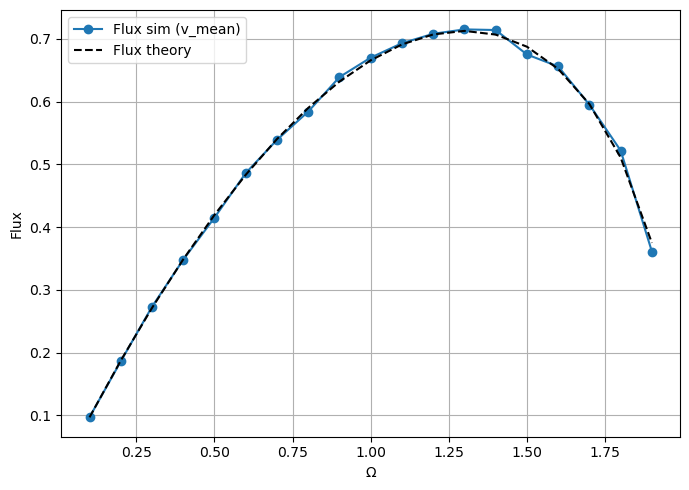

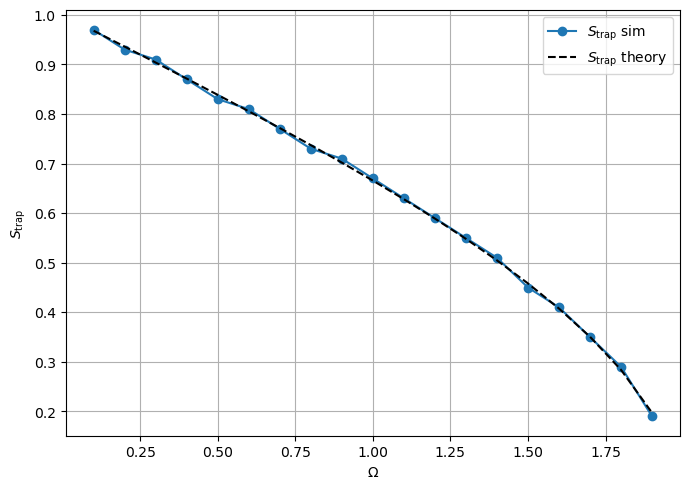

In [12]:
plt.figure(figsize=(7,5))
plt.plot(Omega_arr, flux_omega_list, "o-", label="Flux sim (v_mean)")
plt.plot(Omega_arr, flux_theory,     "k--", label="Flux theory")
plt.xlabel(r"$\Omega$")
plt.ylabel("Flux")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(Omega_arr, Strap_list, "o-", label=r"$S_{\rm trap}$ sim")
plt.plot(Omega_arr, Strap_theory, "k--", label=r"$S_{\rm trap}$ theory")
plt.xlabel(r"$\Omega$")
plt.ylabel(r"$S_{\rm trap}$")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


保存

In [13]:
import pickle

params = {
    "mu_s": mu_s,
    "mu_k": mu_k,
    "Omega_min": Omega_min,
    "Omega_max": Omega_max,
    "n_Omega": n_Omega,
    "N_particles": N_particles,
    "N_cycles": N_cycles,
    "discard_frac": discard_frac,
    "R_hat": R_hat,
    "phi0": phi0,
}

data_Omega = {
    "Omega_list":      Omega_list,
    "flux_vmean_list": flux_vmean_list,
    "flux_omega_list": flux_omega_list,
    "Strap_list":      Strap_list,
    "v_sync_list":     v_sync_list,
    "params":          params,
    # ★ 追加: 初期位相と同期フラグ
    "x0_list":         x0_list,
    "sync_flags_all":  sync_flags_all,   # shape (n_Omega, N_particles)
}

filename = f"results_Omega_mu_s{mu_s:.2f}_mu_k{mu_k:.2f}.pkl"

with open(filename, "wb") as f:
    pickle.dump(data_Omega, f)

print("saved to", filename)


saved to results_Omega_mu_s0.00_mu_k0.00.pkl


ファイルから呼び出し

In [14]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# ===== 1. データ読込 =====
filename = "results/results_Omega_mu_s0.00_mu_k0.00.pkl"  # 実際のファイル名に合わせて
with open(filename, "rb") as f:
    loaded = pickle.load(f)

Omega_list      = loaded["Omega_list"]      # shape (n_Omega,)
flux_vmean_list = loaded["flux_vmean_list"]
flux_omega_list = loaded["flux_omega_list"]
Strap_list      = loaded["Strap_list"]
v_sync_list     = loaded["v_sync_list"]
params          = loaded["params"]
x0_list         = loaded["x0_list"]
sync_flags_all  = loaded["sync_flags_all"]

R_hat = params["R_hat"]
A     = np.exp(-R_hat)
Omega_edge = 2.0 * np.sqrt(A)    # ≈ 1.995

# ===== 2. 端点 Ω=0, Ω=2√A を追加 =====
# フラックス: 両端とも 0
flux_vmean_ext = np.concatenate([[0.0], flux_vmean_list, [0.0]])
flux_omega_ext = np.concatenate([[0.0], flux_omega_list, [0.0]])

# Strap: Ω=0 では 1, Ω=2√A では 0（理論）
Strap_ext = np.concatenate([[1.0], Strap_list, [0.0]])

# v_sync はとりあえず端点 0 にしておく（議論に使わないなら何でもOK）
v_sync_ext = np.concatenate([[0.0], v_sync_list, [0.0]])

Omega_ext = np.concatenate([[0.0], Omega_list, [Omega_edge]])


理論と比較可視化

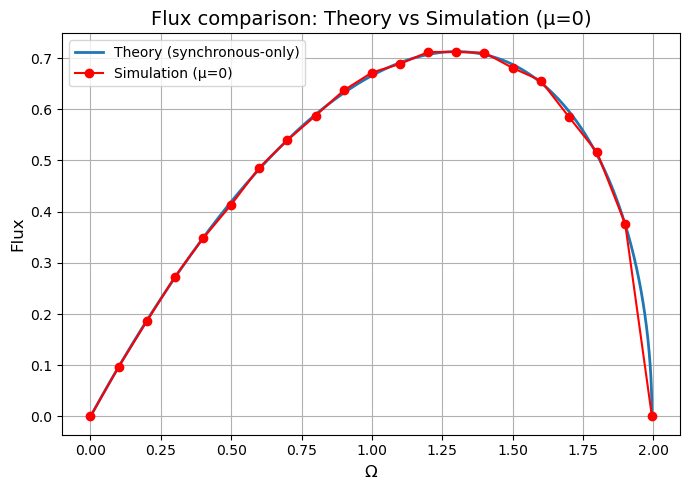

In [15]:
plot_theory_vs_sim(
    Omega_list = Omega_ext,
    flux_sim   = flux_vmean_ext,
    A          = A,
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# x0_list は 0〜2π で並んでいる前提
X, Y = np.meshgrid(x0_list, Omega_list)
Z = sync_flags_all.astype(int)  # True→1, False→0

plt.figure(figsize=(7,4))
pc = plt.pcolormesh(
    X, Y, Z,
    shading="nearest",
    cmap="Greys"  # 白(0)=非同期, 黒(1)=同期
)

plt.xlabel(r"Initial phase $x_0$")
plt.ylabel(r"$\Omega$")
plt.title("Synchronous region in $(x_0, \Omega)$")

# ★ 目盛りを 0, π/2, π, 3π/2, 2π にする
xticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
xtick_labels = ["0", "π/2", "π", "3π/2", "2π"]
plt.xticks(xticks, xtick_labels)

plt.colorbar(pc, label="sync (1) / non-sync (0)")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))

for i, Omega in enumerate(Omega_list):
    sync = sync_flags_all[i]     # shape (N_particles,)
    x0   = x0_list               # 0〜2π

    # 同期点の x0 を抽出
    xs = x0[sync]

    if len(xs) == 0:
        continue

    # 連続区間を求める
    # 隣接点の差が大きいところで区切る
    jumps = np.where(np.diff(xs) > (x0[1] - x0[0])*1.5)[0]

    # 区間の開始・終了 index を作る
    segments = []
    start = 0
    for j in jumps:
        segments.append((xs[start], xs[j]))
        start = j+1
    segments.append((xs[start], xs[-1]))

    # この Ω の高さで帯を描画
    for (a, b) in segments:
        plt.plot([a, b], [Omega, Omega], lw=6, color="black")
        

# 軸ラベル
plt.xlabel(r"Initial phase $x_0$")
plt.ylabel(r"$\Omega$")
plt.title("Synchronous region as phase intervals")

# 目盛りを π 表示に
xticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
xtick_labels = ["0", "π/2", "π", "3π/2", "2π"]
plt.xticks(xticks, xtick_labels)

plt.ylim(min(Omega_list)-0.05, max(Omega_list)+0.05)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Omega_idx = 10  # 例として最初の Ω
Omega0    = Omega_list[Omega_idx]
sync_flags = sync_flags_all[Omega_idx]      # (N_particles,)
S_trap     = Strap_list[Omega_idx]         # その Ω での同期割合

psi0 = x0_list  # 0〜2π
A = np.exp(-R_hat)
psi_plot = np.linspace(0, 2*np.pi, 400)
V_plot = A * np.sin(psi_plot)

plt.figure(figsize=(7,4))
plt.plot(psi_plot, V_plot, label=r"$V(\psi)=A\sin\psi$")

# 同期粒子（赤）
plt.scatter(
    psi0[sync_flags],
    A*np.sin(psi0[sync_flags]),
    color="red",
    label="sync",
    zorder=3,
)

# 非同期粒子（青）
plt.scatter(
    psi0[~sync_flags],
    A*np.sin(psi0[~sync_flags]),
    color="blue",
    label="non-sync",
    zorder=3,
)

plt.xlabel(r"Initial phase $\psi_0$")
plt.ylabel(r"Effective potential $V(\psi)$")

# ★ タイトルに S_trap を表示
plt.title(fr"Initial phases on potential  (Ω={Omega0:.3f},  $S_{{trap}}$={S_trap:.3f})")

# x 軸目盛りを 0, π/2, π, 3π/2, 2π に
xticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
xtick_labels = ["0", "π/2", "π", "3π/2", "2π"]
plt.xticks(xticks, xtick_labels)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Omega = {Omega0:.3f}, S_trap = {S_trap:.6f}")
